# Cardiovascular Disease Risk Factors
#### CHAPTER 02: _Key Concepts of Interpretability_
##### From **Interpretable Machine Learning with Python 2nd Edition** by Serg Masís, published by Packt

## The Preparations

### Installing the Libraries

In [ ]:
!pip install pandas==1.3.5
!pip install numpy==1.21.6
!pip install statsmodels==0.11.0
!pip install scikit-learn==1.0.2
!pip install matplotlib==3.5.1

In [ ]:
!pip install pathlib2==2.3.5
!pip install scipy==1.4.1
!pip install mlxtend==0.19.0
!pip install pycebox==0.0.1
!pip install alibi==0.6.5
!pip install aif360==0.3.0
!pip install opencv-python==4.4.0.44
!pip install tqdm==4.62.3
!pip install seaborn==0.11.0
!pip install alibi==0.6.5

### Loading the Libraries

In [1]:
import math
import mldatasets
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Understanding and Preparing the Data

In [2]:
cvd_df = mldatasets.load("cardiovascular-disease")

https://raw.githubusercontent.com/caravanuden/cardio/master/cardio_train.csv downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/02/data/cardio_train.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/02/data folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/programming/_packt_git/Interpretable-Machine-Learning-with-Python-2E/02/data/cardio_train.csv


In [3]:
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


#### Data Preparation

In [4]:
cvd_df['age'] =  cvd_df['age'] / 365.24

In [5]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

In [6]:
cvd_df.describe(percentiles=[.01,.99]).transpose().style.format('{:.2f}').\
                set_properties(**{'font-size': '16pt'}).set_table_styles(set_header_font())

,count,mean,std,min,1%,50%,99%,max
age,70000.00,53.30,6.76,29.56,39.61,53.95,64.31,64.92
gender,70000.00,1.35,0.48,1.00,1.00,1.00,2.00,2.00
height,70000.00,164.36,8.21,55.00,147.00,165.00,184.00,250.00
weight,70000.00,74.21,14.40,10.00,48.00,72.00,117.00,200.00
ap_hi,70000.00,128.82,154.01,-150.00,90.00,120.00,180.00,16020.00
ap_lo,70000.00,96.63,188.47,-70.00,60.00,80.00,1000.00,11000.00
cholesterol,70000.00,1.37,0.68,1.00,1.00,1.00,3.00,3.00
gluc,70000.00,1.23,0.57,1.00,1.00,1.00,3.00,3.00
smoke,70000.00,0.09,0.28,0.00,0.00,0.00,1.00,1.00
alco,70000.00,0.05,0.23,0.00,0.00,0.00,1.00,1.00


In [7]:
incorrect_l = cvd_df[(cvd_df['ap_hi'] > 370) | (cvd_df['ap_hi'] <= 40) |\
                     (cvd_df['ap_lo'] > 370) | (cvd_df['ap_lo'] <= 40)].index
print(len(incorrect_l) /  cvd_df.shape[0])

0.017728571428571427


In [8]:
cvd_df.drop(incorrect_l, inplace=True)

In [9]:
cvd_df = cvd_df[cvd_df['ap_hi'] >= cvd_df['ap_lo']].reset_index(drop=True)

In [10]:
y = cvd_df['cardio']
X = cvd_df.drop(['cardio'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=9)

## Learning about Interpretation Method Types and Scopes

In [11]:
log_model = sm.Logit(y_train, sm.add_constant(X_train))
log_result = log_model.fit()
print(log_result.summary2())

Optimization terminated successfully.
         Current function value: 0.562145
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.189     
Dependent Variable: cardio           AIC:              65636.3972
Date:               2022-07-12 18:15 BIC:              65744.0896
No. Observations:   58359            Log-Likelihood:   -32806.   
Df Model:           11               LL-Null:          -40448.   
Df Residuals:       58347            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-----------------------------------------------------------------
const         -11.1677   0.2507 -44.5530 0.0000 -11.6590 -10.6764
age             0.0504   0.0015  34.3350 0.0000   0.0475   0.0532


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [12]:
np.exp(log_result.params).sort_values(ascending=False)

cholesterol    1.645409
ap_hi          1.057123
age            1.051662
ap_lo          1.011482
weight         1.010800
height         0.996614
gender         0.994480
gluc           0.887356
smoke          0.865710
alco           0.825331
active         0.782065
const          0.000014
dtype: float64

In [13]:
np.std(X_train, 0)

age             6.753314
gender          0.476652
height          8.186996
weight         14.331368
ap_hi          16.682047
ap_lo           9.434014
cholesterol     0.678979
gluc            0.570598
smoke           0.283529
alco            0.224476
active          0.396201
dtype: float64

In [14]:
coefs = log_result.params.drop(labels=['const','gender'])
stdv = np.std(X_train, 0).drop(labels='gender')
abs(coefs * stdv).sort_values(ascending=False)

ap_hi          0.926707
age            0.340174
cholesterol    0.338124
weight         0.153945
ap_lo          0.107705
active         0.097393
gluc           0.068192
alco           0.043093
smoke          0.040886
height         0.027770
dtype: float64

### Interpreting Individual Predictions with Logistic Regression

In [15]:
y_pred = log_result.predict(sm.add_constant(X_test)).to_numpy()
print(y_pred)

[0.6182222  0.33604015 0.21126989 ... 0.30789012 0.26143349 0.31372653]


In [16]:
print(y_pred[2872])

0.3792254083863881


In [17]:
print(X_test.iloc[2872])

age             51.620852
gender           2.000000
height         165.000000
weight          64.000000
ap_hi          120.000000
ap_lo           80.000000
cholesterol      1.000000
gluc             1.000000
smoke            0.000000
alco             0.000000
active           0.000000
Name: 19040, dtype: float64


In [18]:
filler_feature_values = {"age": 30, "gender": 1, "height": 165, "weight": 57, "ap_hi": 110, 
                         "ap_lo": 70, "cholesterol": 1, "gluc": 1, "smoke": 0, "alco":0, "active":1
                    }

In [19]:
X_highlight = np.reshape(\
       np.concatenate(([1], X_test.iloc[2872].to_numpy())), (1, 12))
print(X_highlight)


[[  1.          51.62085204   2.         165.          64.
  120.          80.           1.           1.           0.
    0.           0.        ]]


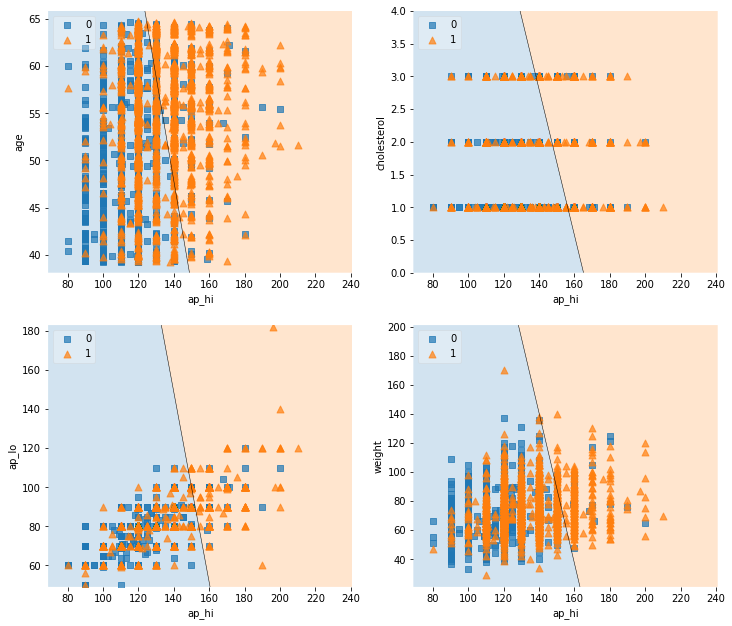

In [20]:
plt.rcParams.update({'font.size': 14, 'figure.dpi':300})
fig, axarr = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=False)
mldatasets.create_decision_plot(X_test, y_test, log_result, ["ap_hi", "age"], None, 
                     X_highlight, filler_feature_values, ax=axarr.flat[0])
mldatasets.create_decision_plot(X_test, y_test, log_result, ["ap_hi", "cholesterol"], None, 
                     X_highlight, filler_feature_values, ax=axarr.flat[1])
mldatasets.create_decision_plot(X_test, y_test, log_result, ["ap_hi", "ap_lo"], None, 
                     X_highlight, filler_feature_values, ax=axarr.flat[2])
mldatasets.create_decision_plot(X_test, y_test, log_result, ["ap_hi", "weight"], None, 
                     X_highlight, filler_feature_values, ax=axarr.flat[3])
plt.subplots_adjust(top = 1, bottom=0, hspace=0.2, wspace=0.2)
plt.show()

## Appreciate what Hinders Machine Learning Interpretability

No contour levels were found within the data range.


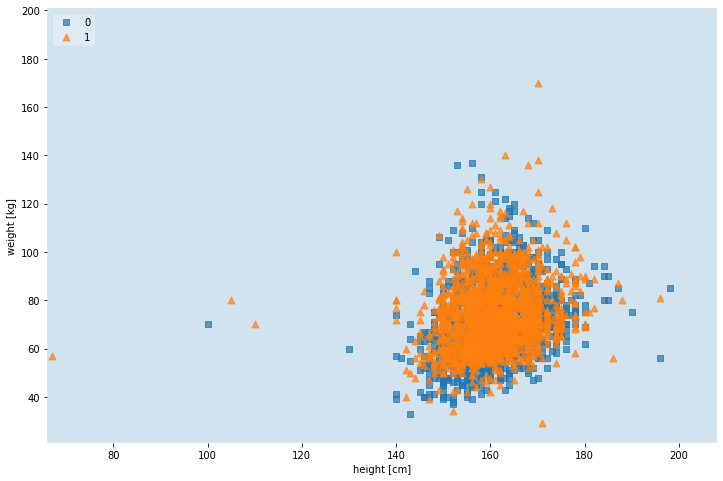

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
mldatasets.create_decision_plot(X_test, y_test, log_result, [3,4], ['height [cm]', 'weight [kg]'], 
                     X_highlight, filler_feature_values, ax=ax)
plt.show()

### Non-Linearity

In [22]:
X2 = cvd_df.drop(['cardio'], axis=1).copy()
X2["bmi"] = X2["weight"] / (X2["height"]/100)**2

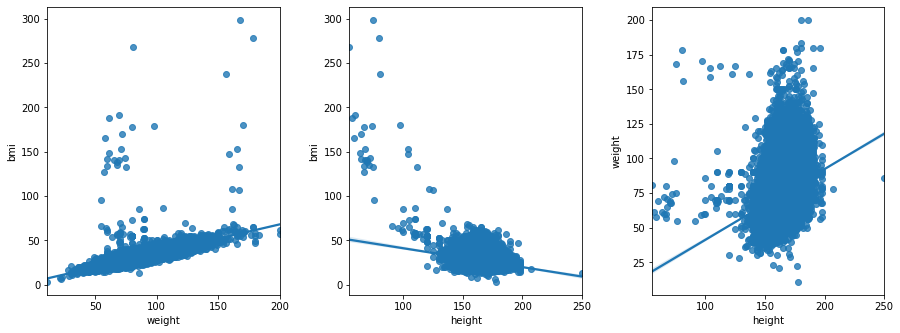

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
sns.regplot(x="weight", y="bmi", data=X2, ax=ax1)
sns.regplot(x="height", y="bmi", data=X2, ax=ax2)
sns.regplot(x="height", y="weight", data=X2, ax=ax3)
plt.subplots_adjust(top = 1, bottom=0, hspace=0.2, wspace=0.3)
plt.show()

In [24]:
X2 = X2.drop(['weight','height'], axis=1)
X2_train, X2_test, _, _ = train_test_split(X2, y, test_size=0.15, random_state=9)
log_model2 = sm.Logit(y_train, sm.add_constant(X2_train))
log_result2 = log_model2.fit()

Optimization terminated successfully.
         Current function value: 0.562766
         Iterations 6


In [25]:
sns.reset_orig()

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


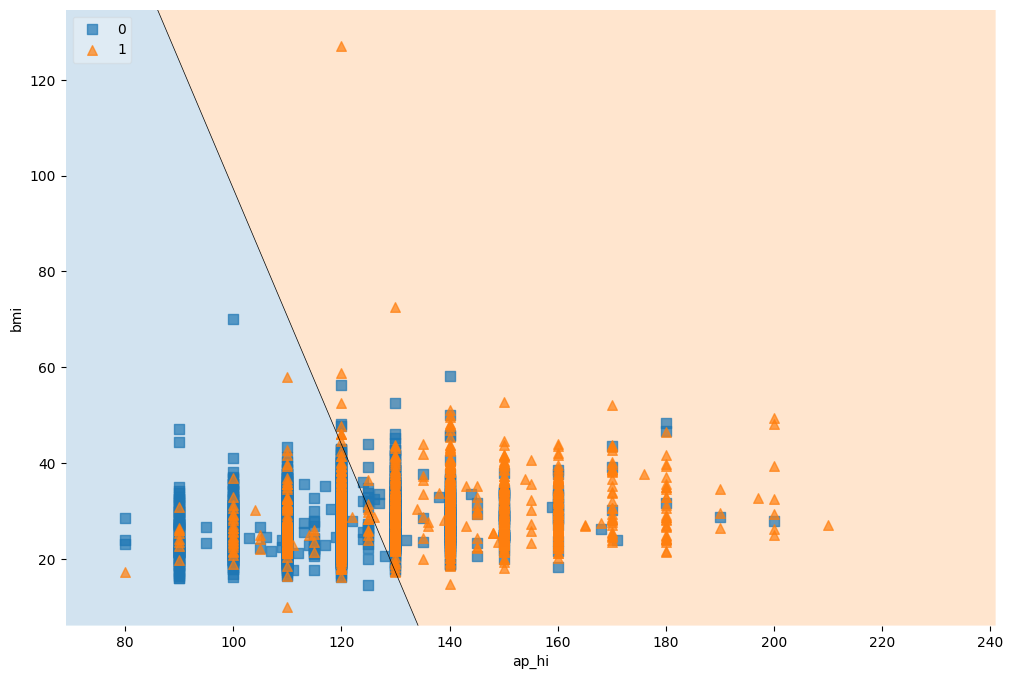

In [26]:
filler_feature_values2 = {"age": 60, "gender": 1, "ap_hi": 110, "ap_lo": 70, "cholesterol": 1, "gluc": 1,\
                          "smoke": 0, "alco":0, "active":1, "bmi":20}
X2_highlight = np.reshape(np.concatenate(([1],X2_test.iloc[2872].to_numpy())), (1, 11))

fig, ax = plt.subplots(1,1, figsize=(12,8))
mldatasets.create_decision_plot(X2_test, y_test, log_result2, ["ap_hi", "bmi"], None,
                     X2_highlight, filler_feature_values2, ax=ax)
plt.show()